Jinglin Zhang z5405642

# Taxi Navigation with Reinforcement Learning

## 1. initializations

In [9]:
%pip install gym
%pip install pygame

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gym

In [11]:
# environment initialization
env = gym.make('Taxi-v3', render_mode = 'ansi')
Nstates = env.observation_space.n
Nactions = env.action_space.n
Nstates, Nactions

(500, 6)

In [12]:
# Reset the environment, which returns the initial state
state = env.reset()
# Render the environment, which returns the rendering result as an ANSI string
rendered_env = env.render()
# Print the rendering result
print(rendered_env)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




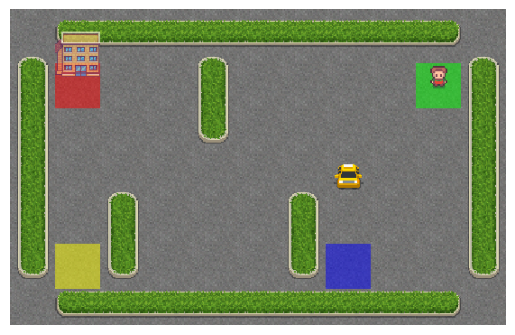

In [13]:
env = gym.make('Taxi-v3', render_mode = 'rgb_array')
state = env.reset()
rendered_env = env.render()
plt.imshow(rendered_env)
plt.axis('off') 
plt.show()

## 2. Action selection methods

### 2.1 greedy / ϵ-greedy

The $\epsilon$-greedy strategy is a commonly used algorithm in reinforcement learning to balance exploration and exploitation. It selects a random action with probability $\epsilon$ and selects the action with the highest Q-value with probability \(1 - $\epsilon$).

1. With probability $\epsilon$, select a random action:
   $
   a_t = \text{random action}
   $

2. With probability \(1 - $\epsilon$), select the action that maximizes the Q-value:
   $
   a_t = \arg\max_{a} Q(s_t, a)
   $

Explanation:
- $\epsilon$: The exploration rate, a parameter between 0 and 1, which determines the likelihood of choosing a random action. If $\epsilon$ = 0, it indicates a greedy method.
- $a_t$: The action chosen at time step $t$.
- $s_t$: The current state at time step $t$.
- $Q(s_t, a)$: The Q-value of taking action $a$ in state $s_t$.
- $\arg\max_{a} Q(s_t, a)$: The action that has the highest Q-value for the current state $s_t$.

In [28]:
# greedy -> epsilon = 0
def epsilon_greedy_method(Q_values, epsilon, state):
    if np.random.uniform(0,1) < epsilon:
        action = np.random.choice(Nactions)
    else:
        action = np.argmax(Q_values[state, :])
    return action

### 2.2 softmax

The Softmax method is a more refined exploration and exploitation balancing strategy. In this method, the probability of each action being selected is proportional to the exponential value of its estimated value. The probability $P(a)$ of selecting action $a$ at time $t$ is calculated using the following formula:

$
P(a) = \frac{\exp(Q_t(a) / \tau)}{\sum_{a'} \exp(Q_t(a') / \tau)}
$

where $\tau$ is the temperature parameter that controls the balance between exploration and exploitation:

- When $\tau$ is large (high temperature), the probabilities of selecting all actions become closer to equal, resulting in more exploration.
- When $\tau$ is small (low temperature), the probability of selecting actions with higher estimated values is significantly higher, resulting in more exploitation.

In [29]:
def softmax_method(Q_values, tau, state):
    p_state = Q_values[state] / tau
    exp_p = np.exp(p_state - np.max(p_state))
    probabilities = exp_p / np.sum(exp_p)
    action = np.random.choice(len(Q_values[state]), p = probabilities)
    return action

## 3. Training functions

### Exponential Decay Schedule
- Alpha (α) Decay
  Alpha is the learning rate, which controls how much the Q-values are updated during learning. A high alpha means that new information will have a large impact on the Q-values, while a low alpha means that new information will have a small impact. Decaying alpha over time allows the agent to stabilize its learning process by gradually reducing the impact of new information.
- Epsilon (ε) Decay
  Epsilon is used in the epsilon-greedy policy for action selection. It represents the probability of choosing a random action instead of the action suggested by the current policy (i.e., the action with the highest Q-value). Initially, epsilon is set to a high value to encourage exploration. Over time, as the agent learns more about the environment, epsilon is decayed to reduce the amount of exploration and exploit the learned policy more.
- Tau (τ) Decay
  Tau decay involves reducing the value of tau over time to make the updates to the target network parameters more conservative as learning progresses. Initially, a higher tau might be used to allow faster updates and exploration, but as the agent learns more about the environment, tau is decayed to stabilize learning.

In [30]:
def exponential_decay(initial_value, minimum_value, decay_proportion, total_steps):
    # Calculate the number of steps for decay
    n_steps = int(total_steps * decay_proportion)
    # Calculate the remaining steps after decay
    remaining_steps = total_steps - n_steps
    # Generate logarithmically spaced values for decay
    decay_values = np.logspace(-2, 0, n_steps, base=10, endpoint=True)[::-1]
    # Normalize the decay values to range between 0 and 1
    decay_values = (decay_values - decay_values.min()) / (decay_values.max() - decay_values.min())
    # Scale the decay values to range between initial_value and minimum_value
    decay_values = (initial_value - minimum_value) * decay_values + minimum_value
    # Pad the remaining values with the minimum_value
    decay_schedule = np.pad(decay_values, (0, remaining_steps), 'edge')
    return decay_schedule

### Q-learning (off-policy)

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha (\text{Reward}_{t+1} + \gamma \max_a Q(S_{t+1}, \text{all\_actions}) - Q(S_t,A_t))$

Explanation:
- $Q(S_t,A_t)$: The Q-value for the current state and action.
- $\alpha$ (alpha): The learning rate, which controls the step size of the Q-value update.
- $\text{Reward}_{t+1}$: The reward received after taking the current action.
- $\gamma$ (gamma): The discount factor, balancing the importance of current and future rewards.
- $\max_a Q(S_{t+1}, \text{all\_actions})$: The maximum Q-value for all possible actions in the next state.

By continually updating the Q-values, the Q-learning algorithm progressively optimizes the policy, enabling the selection of actions that maximize the long-term cumulative reward in any given state.

#### epsilon-greedy

In [31]:
def train_Q_learning_greedy(env, episodes, alpha, gamma, epsilon, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = epsilon_greedy_method(Q_values, epsilon, state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = epsilon_greedy_method(Q_values, epsilon, next_state)
            Q_values[state, action] = Q_values[state, action] + alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode

In [32]:
# with alpha decay and epsilon decay

def train_Q_learning_greedy_decay(env, episodes, alphas, gamma, epsilons, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = epsilon_greedy_method(Q_values, epsilons[i], state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = epsilon_greedy_method(Q_values, epsilons[i], next_state)
            Q_values[state, action] = Q_values[state, action] + alphas[i] * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode


#### softmax

In [33]:
def train_Q_learning_softmax(env, episodes, alpha, gamma, tau, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = softmax_method(Q_values, tau, state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = softmax_method(Q_values, tau, next_state)
            Q_values[state, action] = Q_values[state, action] + alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode

In [34]:
# with alpha decay and tau decay

def train_Q_learning_softmax_decay(env, episodes, alphas, gamma, taus, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = softmax_method(Q_values, taus[i], state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = softmax_method(Q_values, taus[i], next_state)
            Q_values[state, action] = Q_values[state, action] + alphas[i] * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode

### SARSA (on-policy)

$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha (\text{Reward}_{t+1} + \gamma  Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t))$

Explanation
- $Q(S_t,A_t)$: The Q-value for taking action $A_t$ in state $S_t$. 
- $\alpha$ (alpha):  The learning rate, which determines how much new information overrides the old information. It is a value between 0 and 1.
- $\text{Reward}_{t+1}$: This is the reward received immediately after taking action $A_t$ and moving to the next state $S_{t+1}$.
- $\gamma$ (gamma): This parameter determines the importance of future rewards. A $\gamma$ value close to 1 makes the agent value future rewards more, while a value close to 0 makes the agent focus more on immediate rewards.
- $Q(S_{t+1}, A_{t+1})$: This is the Q-value for the next state-action pair $S_{t+1}, A_{t+1}$ . It represents the agent’s estimate of the value of taking action $A_{t+1}$ in the next state $S_{t+1}$.

#### epsilon-greedy

In [35]:
def train_SARSA_greedy(env, episodes, alpha, gamma, epsilon, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = epsilon_greedy_method(Q_values, epsilon, state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = epsilon_greedy_method(Q_values, epsilon, next_state)   
            Q_values[state, action] = Q_values[state, action] + alpha * (reward + gamma * Q_values[next_state, next_action] - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode


In [36]:
# with alpha decay and epsilon decay

def train_SARSA_greedy_decay(env, episodes, alphas, gamma, epsilons, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = epsilon_greedy_method(Q_values, epsilons[i], state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = epsilon_greedy_method(Q_values, epsilons[i], next_state)   
            Q_values[state, action] = Q_values[state, action] + alphas[i] * (reward + gamma * Q_values[next_state, next_action] - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)
        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode


#### softmax

In [37]:
def train_SARSA_softmax(env, episodes, alpha, gamma, tau, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = softmax_method(Q_values, tau, state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = softmax_method(Q_values, tau, next_state)   
            Q_values[state, action] = Q_values[state, action] + alpha * (reward + gamma * Q_values[next_state, next_action] - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode


In [38]:
# with alpha decay and tau decay

def train_SARSA_softmax_decay(env, episodes, alphas, gamma, taus, n):
    # q_table
    Q_values = np.zeros([Nstates, Nactions])  # (500, 6) state-action pair

    # For plotting metrics
    steps_per_episode = [] 
    accumulated_rewards =[]
    
    for i in range(episodes):
        state, _ = env.reset()
        done = False
        rewards = 0
        n_steps = 0
        action = softmax_method(Q_values, taus[i], state)

        while not done:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = softmax_method(Q_values, taus[i], next_state)   
            Q_values[state, action] = Q_values[state, action] + alphas[i] * (reward + gamma * Q_values[next_state, next_action] - Q_values[state, action])
            state, action = next_state, next_action
            rewards += reward
            n_steps += 1
        
        accumulated_rewards.append(rewards)
        steps_per_episode.append(n_steps)

        if (i + 1) % 100 == 0:
            print(f"Episode {i+1}, accumulated rewards = {rewards}, steps per episode = {n_steps}")

    print(f"Average reward: {np.mean(accumulated_rewards[n:])}")
    print(f"Average steps per episode: {np.mean(steps_per_episode[n:])}")
    
    return Q_values, accumulated_rewards, steps_per_episode


## 4. Experiment

In [39]:
import matplotlib.pyplot as plt

# show plots
def show_plot(rewards, steps, policy):
    episodes = range(len(rewards))
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label='Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Accumulated Reward')
    plt.title(f'{policy} Over Episodes(Learning)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodes, steps, label='Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'{policy} Steps Per Episodes(Learning)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Q-learning (epsilon-greedy)

Episode 100, accumulated rewards = -6, steps per episode = 27
Episode 200, accumulated rewards = -5, steps per episode = 26
Episode 300, accumulated rewards = -8, steps per episode = 29
Episode 400, accumulated rewards = 9, steps per episode = 12
Episode 500, accumulated rewards = 5, steps per episode = 16
Episode 600, accumulated rewards = 14, steps per episode = 7
Episode 700, accumulated rewards = 7, steps per episode = 14
Episode 800, accumulated rewards = 14, steps per episode = 7
Episode 900, accumulated rewards = 7, steps per episode = 14
Episode 1000, accumulated rewards = 5, steps per episode = 16
Episode 1100, accumulated rewards = 10, steps per episode = 11
Episode 1200, accumulated rewards = 6, steps per episode = 15
Episode 1300, accumulated rewards = 7, steps per episode = 14
Episode 1400, accumulated rewards = 3, steps per episode = 18
Episode 1500, accumulated rewards = 6, steps per episode = 15
Episode 1600, accumulated rewards = 7, steps per episode = 14
Episode 1700,

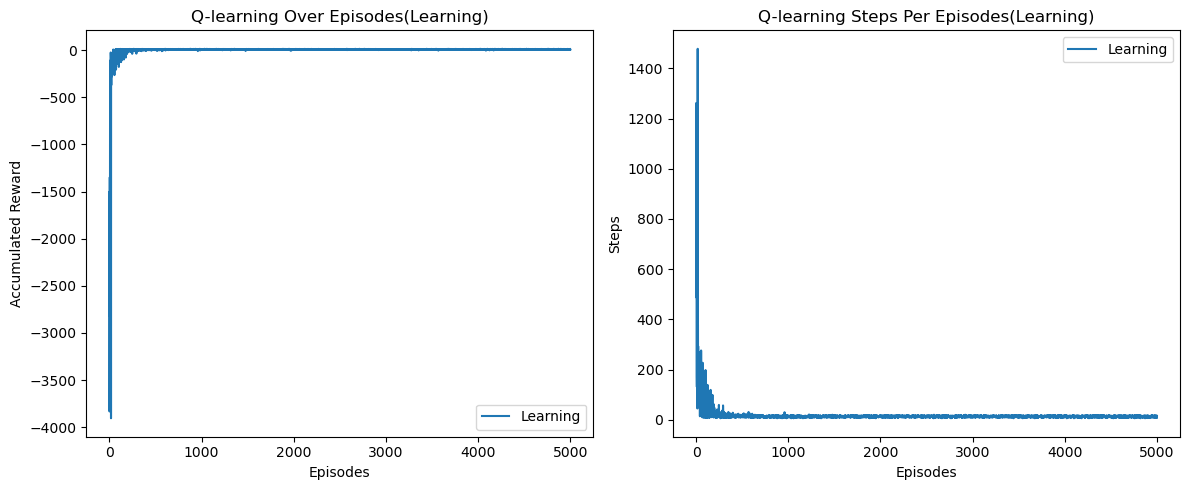

In [278]:
# Hyperparameters
alpha = 0.64  # learning rate
epsilon = 0.001  # expoloration parameter
gamma = 0.9  # discount factor
episodes = 5000

Q_q_learning1, rewards_q_learning1, steps_q_learning1 = train_Q_learning_greedy(env, episodes, alpha, gamma, epsilon, 4000)
show_plot(rewards_q_learning1, steps_q_learning1, "Q-learning")  # type: ignore

Episode 100, accumulated rewards = -21, steps per episode = 42
Episode 200, accumulated rewards = 12, steps per episode = 9
Episode 300, accumulated rewards = 12, steps per episode = 9
Episode 400, accumulated rewards = 6, steps per episode = 15
Episode 500, accumulated rewards = 7, steps per episode = 14
Episode 600, accumulated rewards = 12, steps per episode = 9
Episode 700, accumulated rewards = 4, steps per episode = 17
Episode 800, accumulated rewards = 9, steps per episode = 12
Episode 900, accumulated rewards = 10, steps per episode = 11
Episode 1000, accumulated rewards = 8, steps per episode = 13
Episode 1100, accumulated rewards = 6, steps per episode = 15
Episode 1200, accumulated rewards = 10, steps per episode = 11
Episode 1300, accumulated rewards = 7, steps per episode = 14
Episode 1400, accumulated rewards = 11, steps per episode = 10
Episode 1500, accumulated rewards = 10, steps per episode = 11
Episode 1600, accumulated rewards = 6, steps per episode = 15
Episode 170

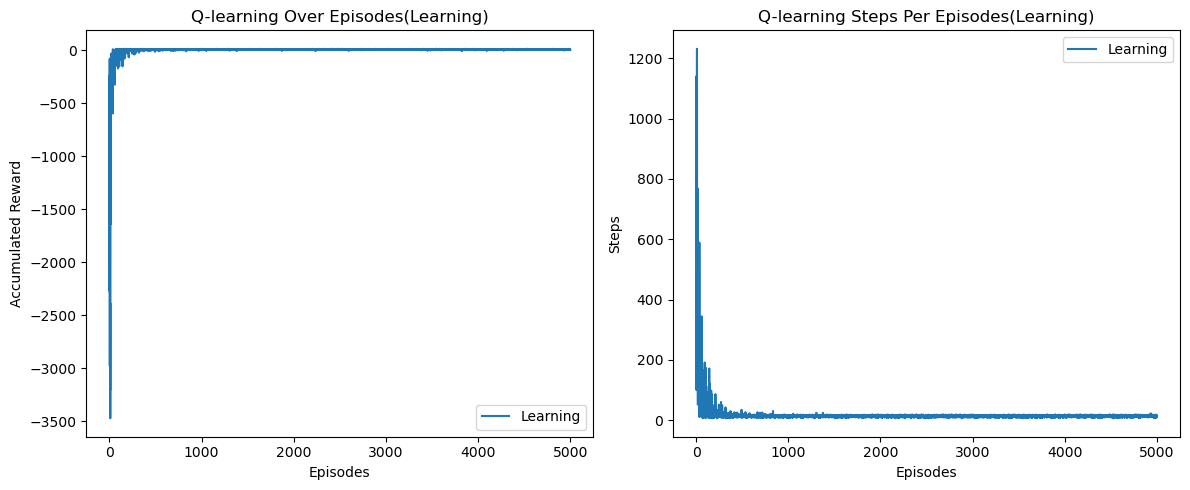

In [238]:
# Hyperparameters
gamma = 0.9  # discount factor
episodes = 5000
alphas = exponential_decay(0.8, 0.7, 0.3, episodes)   # alpha decay
epsilons = exponential_decay(0.01, 0.001, 0.3, episodes)  # epsilon decay

Q_q_learning2, rewards_q_learning2, steps_q_learning2 = train_Q_learning_greedy_decay(env, episodes, alphas, gamma, epsilons, 4000)
show_plot(rewards_q_learning2, steps_q_learning2, "Q-learning") # type: ignore

### Q-learning (softmax)

Episode 100, accumulated rewards = -18, steps per episode = 39
Episode 200, accumulated rewards = -71, steps per episode = 92
Episode 300, accumulated rewards = 7, steps per episode = 14
Episode 400, accumulated rewards = 11, steps per episode = 10
Episode 500, accumulated rewards = 8, steps per episode = 13
Episode 600, accumulated rewards = 3, steps per episode = 18
Episode 700, accumulated rewards = 11, steps per episode = 10
Episode 800, accumulated rewards = 8, steps per episode = 13
Episode 900, accumulated rewards = 6, steps per episode = 15
Episode 1000, accumulated rewards = 6, steps per episode = 15
Episode 1100, accumulated rewards = 14, steps per episode = 7
Episode 1200, accumulated rewards = 5, steps per episode = 16
Episode 1300, accumulated rewards = 8, steps per episode = 13
Episode 1400, accumulated rewards = 10, steps per episode = 11
Episode 1500, accumulated rewards = 6, steps per episode = 15
Episode 1600, accumulated rewards = 4, steps per episode = 17
Episode 17

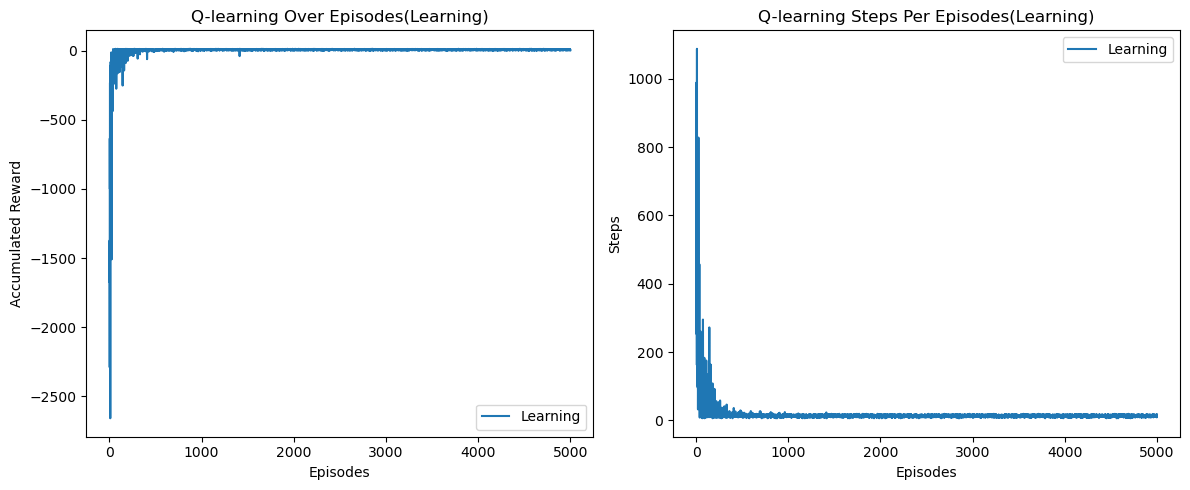

In [279]:
# Hyperparameters
alpha = 0.7  # learning rate
gamma = 0.9  # discount factor
tau = 0.01  # temperature
episodes = 5000

Q_q_learning3, rewards_q_learning3, steps_q_learning3 = train_Q_learning_softmax(env, episodes, alpha, gamma, tau, 4000)
show_plot(rewards_q_learning3, steps_q_learning3, "Q-learning") # type: ignore

Episode 100, accumulated rewards = -10, steps per episode = 31
Episode 200, accumulated rewards = -12, steps per episode = 33
Episode 300, accumulated rewards = 8, steps per episode = 13
Episode 400, accumulated rewards = 10, steps per episode = 11
Episode 500, accumulated rewards = 6, steps per episode = 15
Episode 600, accumulated rewards = 8, steps per episode = 13
Episode 700, accumulated rewards = 6, steps per episode = 15
Episode 800, accumulated rewards = 4, steps per episode = 17
Episode 900, accumulated rewards = 7, steps per episode = 14
Episode 1000, accumulated rewards = 5, steps per episode = 16
Episode 1100, accumulated rewards = 7, steps per episode = 14
Episode 1200, accumulated rewards = 3, steps per episode = 18
Episode 1300, accumulated rewards = 8, steps per episode = 13
Episode 1400, accumulated rewards = 7, steps per episode = 14
Episode 1500, accumulated rewards = 7, steps per episode = 14
Episode 1600, accumulated rewards = 8, steps per episode = 13
Episode 1700

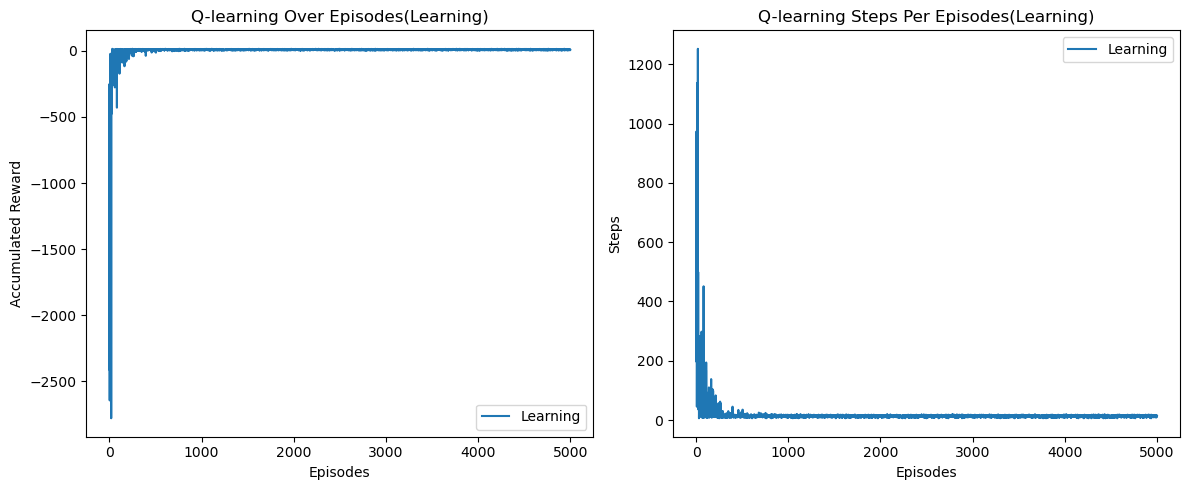

In [292]:
# Hyperparameters
gamma = 0.9  # discount factor
episodes = 5000
alphas = exponential_decay(0.7, 0.6, 0.3, episodes)   # alpha decay
taus = exponential_decay(0.1, 0.001, 0.3, episodes)  # taus decay

Q_q_learning4, rewards_q_learning4, steps_q_learning4 = train_Q_learning_softmax_decay(env, episodes, alphas, gamma, taus, 4000)
show_plot(rewards_q_learning4, steps_q_learning4, "Q-learning") # type: ignore

### SARSA (epsilon-greedy)

Episode 100, accumulated rewards = -83, steps per episode = 104
Episode 200, accumulated rewards = 11, steps per episode = 10
Episode 300, accumulated rewards = -13, steps per episode = 34
Episode 400, accumulated rewards = 6, steps per episode = 15
Episode 500, accumulated rewards = 6, steps per episode = 15
Episode 600, accumulated rewards = 10, steps per episode = 11
Episode 700, accumulated rewards = 7, steps per episode = 14
Episode 800, accumulated rewards = 7, steps per episode = 14
Episode 900, accumulated rewards = 9, steps per episode = 12
Episode 1000, accumulated rewards = 5, steps per episode = 16
Episode 1100, accumulated rewards = 13, steps per episode = 8
Episode 1200, accumulated rewards = 11, steps per episode = 10
Episode 1300, accumulated rewards = 12, steps per episode = 9
Episode 1400, accumulated rewards = 11, steps per episode = 10
Episode 1500, accumulated rewards = 11, steps per episode = 10
Episode 1600, accumulated rewards = 9, steps per episode = 12
Episode

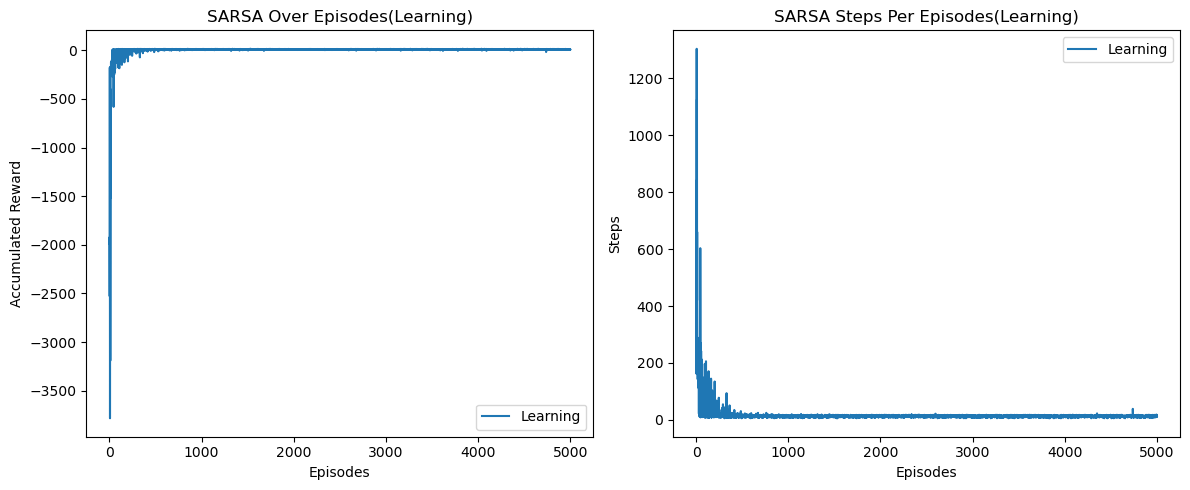

In [49]:
# Hyperparameters
alpha = 0.55  # learning rate
epsilon = 0.001  # expoloration parameter
gamma = 0.9  # discount factor
episodes = 5000

Q_sarsa1, rewards_sarsa1, steps_sarsa1 = train_SARSA_greedy(env, episodes, alpha, gamma, epsilon, 4000)
show_plot(rewards_sarsa1, steps_sarsa1, "SARSA") # type: ignore

Episode 100, accumulated rewards = -78, steps per episode = 81
Episode 200, accumulated rewards = 9, steps per episode = 12
Episode 300, accumulated rewards = 1, steps per episode = 20
Episode 400, accumulated rewards = -770, steps per episode = 701
Episode 500, accumulated rewards = 7, steps per episode = 14
Episode 600, accumulated rewards = 11, steps per episode = 10
Episode 700, accumulated rewards = 10, steps per episode = 11
Episode 800, accumulated rewards = 0, steps per episode = 12
Episode 900, accumulated rewards = 0, steps per episode = 21
Episode 1000, accumulated rewards = 3, steps per episode = 18
Episode 1100, accumulated rewards = 10, steps per episode = 11
Episode 1200, accumulated rewards = 2, steps per episode = 19
Episode 1300, accumulated rewards = 1, steps per episode = 20
Episode 1400, accumulated rewards = 11, steps per episode = 10
Episode 1500, accumulated rewards = 6, steps per episode = 15
Episode 1600, accumulated rewards = 1, steps per episode = 20
Episode

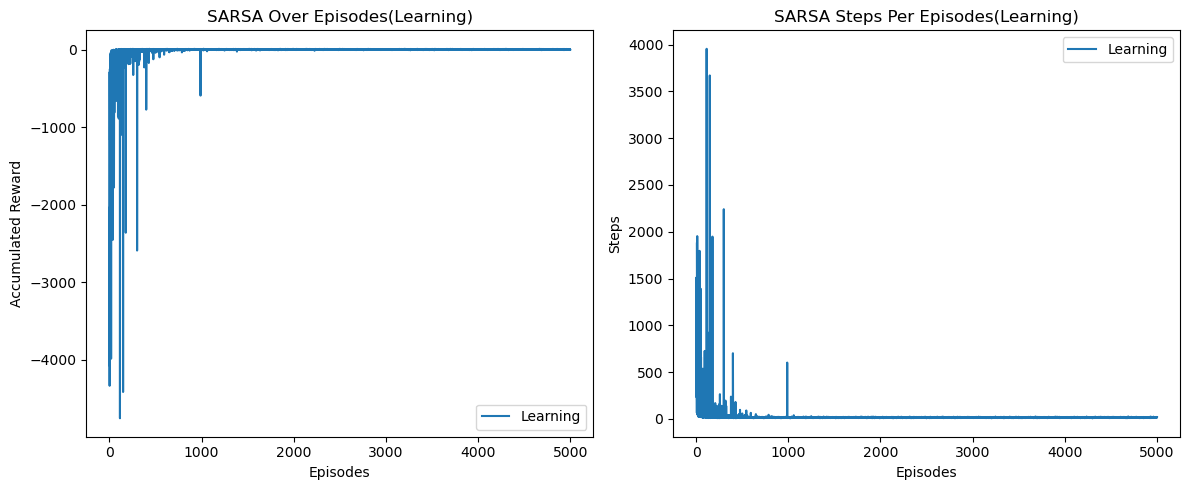

In [48]:
# Hyperparameters
gamma = 0.9  # discount factor
episodes = 5000
alphas = exponential_decay(0.6, 0.2, 0.4, episodes)   # alpha decay
epsilons = exponential_decay(0.1, 0.001, 0.4, episodes)  # epsilon decay

Q_sarsa2, rewards_sarsa2, steps_sarsa2 = train_SARSA_greedy_decay(env, episodes, alphas, gamma, epsilons, 4000)
show_plot(rewards_sarsa2, steps_sarsa2, "SARSA") # type: ignore

### SARSA (softmax)

Episode 100, accumulated rewards = -22, steps per episode = 43
Episode 200, accumulated rewards = 2, steps per episode = 19
Episode 300, accumulated rewards = -61, steps per episode = 37
Episode 400, accumulated rewards = 8, steps per episode = 13
Episode 500, accumulated rewards = 2, steps per episode = 19
Episode 600, accumulated rewards = -17, steps per episode = 20
Episode 700, accumulated rewards = 6, steps per episode = 15
Episode 800, accumulated rewards = 6, steps per episode = 15
Episode 900, accumulated rewards = 8, steps per episode = 13
Episode 1000, accumulated rewards = 7, steps per episode = 14
Episode 1100, accumulated rewards = 10, steps per episode = 11
Episode 1200, accumulated rewards = 10, steps per episode = 11
Episode 1300, accumulated rewards = 10, steps per episode = 11
Episode 1400, accumulated rewards = 10, steps per episode = 11
Episode 1500, accumulated rewards = 7, steps per episode = 14
Episode 1600, accumulated rewards = 8, steps per episode = 13
Episode

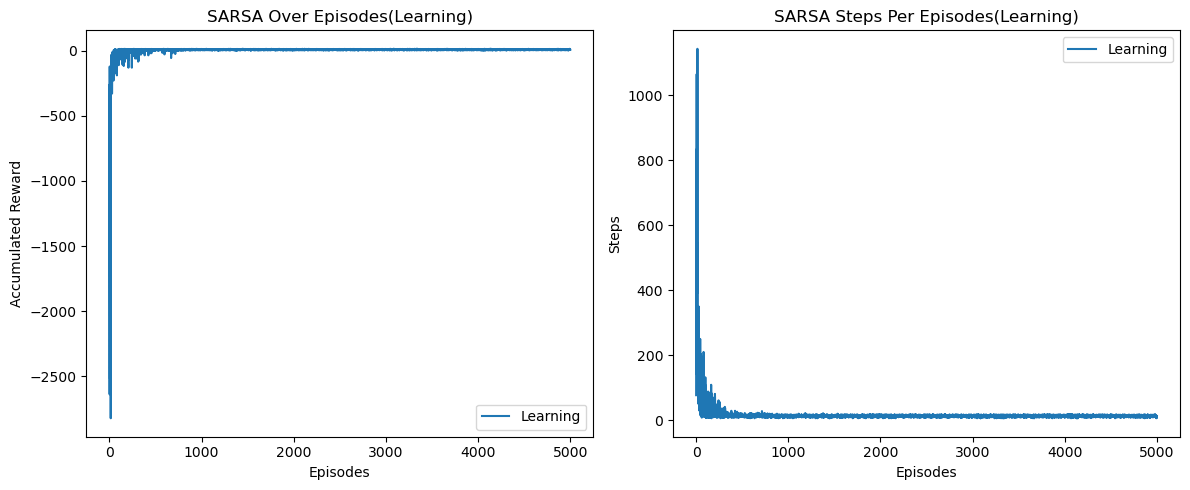

In [35]:
# Hyperparameters
alpha = 0.6  # learning rate
gamma = 0.9  # discount factor
tau = 0.01  # temperature
episodes = 5000

Q_sarsa3, rewards_sarsa3, steps_sarsa3 = train_SARSA_softmax(env, episodes, alpha, gamma, tau, 4000)
show_plot(rewards_sarsa3, steps_sarsa3, "SARSA") # type: ignore

Episode 100, accumulated rewards = 11, steps per episode = 10
Episode 200, accumulated rewards = 5, steps per episode = 16
Episode 300, accumulated rewards = 7, steps per episode = 14
Episode 400, accumulated rewards = 7, steps per episode = 14
Episode 500, accumulated rewards = 8, steps per episode = 13
Episode 600, accumulated rewards = 6, steps per episode = 15
Episode 700, accumulated rewards = 7, steps per episode = 14
Episode 800, accumulated rewards = 8, steps per episode = 13
Episode 900, accumulated rewards = 7, steps per episode = 14
Episode 1000, accumulated rewards = 12, steps per episode = 9
Episode 1100, accumulated rewards = 5, steps per episode = 16
Episode 1200, accumulated rewards = 10, steps per episode = 11
Episode 1300, accumulated rewards = 5, steps per episode = 16
Episode 1400, accumulated rewards = 14, steps per episode = 7
Episode 1500, accumulated rewards = 10, steps per episode = 11
Episode 1600, accumulated rewards = 12, steps per episode = 9
Episode 1700, 

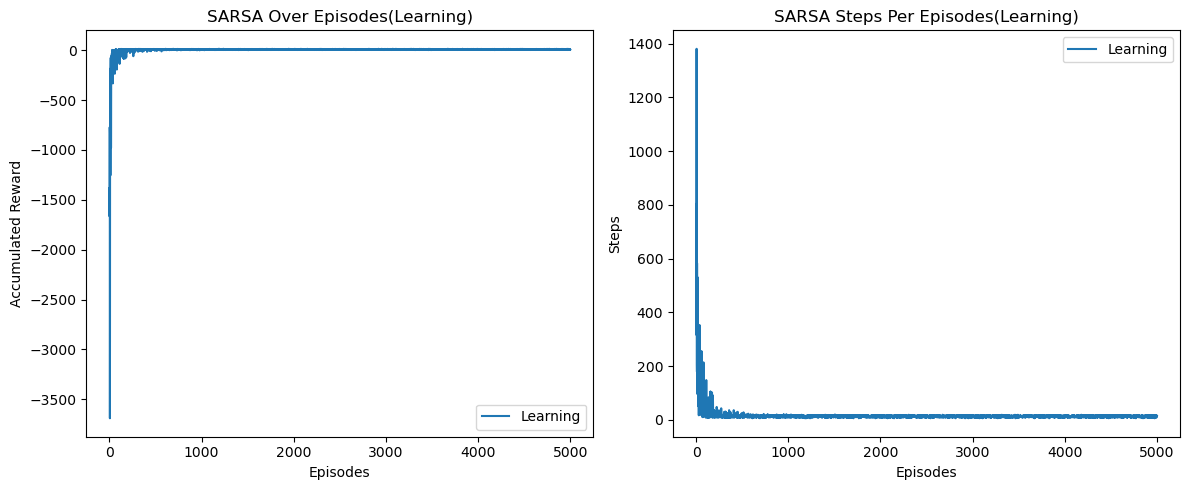

In [320]:
# Hyperparameters
gamma = 0.9  # discount factor
episodes = 5000
alphas = exponential_decay(0.7, 0.5, 0.3, episodes)   # alpha decay
taus = exponential_decay(0.1, 0.001, 0.3, episodes)  # taus decay

Q_sarsa4, rewards_sarsa4, steps_sarsa4 = train_SARSA_softmax_decay(env, episodes, alphas, gamma, taus, 4000)
show_plot(rewards_sarsa4, steps_sarsa4, "SARSA") # type: ignore

### Save trained Q_values 

After the fine-tuning process, the epsilon-greedy model without decay schedules performed best for the Q-learning algorithm, while the softmax model with decay schedules was the top performer for the SARSA algorithm. Consequently, we save the Q-values from these two models and use the saved Q-values for testing.

In [321]:
np.save("q_learning_Q.npy", Q_q_learning1)
np.save("sarsa_Q.npy", Q_sarsa4)

## 5. Test and visualize the trained agents

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import random

env = gym.make('Taxi-v3', render_mode = 'rgb_array')


In [13]:
# all_initial_info = [initial state for episode0, initial state for episode1, initial state for episode2, ...]
# all_visualize_info = [[steps, state, action, reward, rewards for episode0], [steps, state, action, reward, rewards for episode1], ...]

def rl_test(env, episodes, Q):
    env = gym.make('Taxi-v3', render_mode = 'rgb_array')
    all_rewards_per_episode = []
    all_steps_per_episode = []
    all_rendered_env = []
    all_visualize_info = []
    all_initial = []
    all_env_seeds = []

    for i in range(episodes):
        inital_per_episode = []
        seed = random.randint(0, 800)
        all_env_seeds.append(seed)
        state, _ = env.reset(seed = seed)
        rendered_inital = env.render()
        done = False
        rewards = 0
        steps = 0
        inital_per_episode.append([rendered_inital, state])
        visualize_info_per_episode = []
        rendered_env_per_episode = []
        while not done:
            action = np.argmax(Q[state, :])
            next_state, reward, done, truncated, info = env.step(action)
            rewards += reward
            steps += 1
            visualize_info_per_episode.append([steps, state, action, reward, rewards])
            state = next_state
            rendered_env = env.render()
            rendered_env_per_episode.append(rendered_env)

            if steps >= 99:
                break

        all_rewards_per_episode.append(rewards)
        all_steps_per_episode.append(steps)
        all_visualize_info.append(visualize_info_per_episode)
        all_rendered_env.append(rendered_env_per_episode)
        all_initial.append(inital_per_episode)
    
    print(f"Average reward: {np.mean(all_rewards_per_episode)}")
    print(f"Average steps per episode: {np.mean(all_steps_per_episode)}")
    return all_rendered_env, all_visualize_info, all_initial, all_env_seeds, all_rewards_per_episode, all_steps_per_episode

In [14]:
# render with env_rgb or env_human
# episode is a number between 0 and 99
# visualize the selected episode render "rgb_array"

def visualization_rgb(episode, all_rendered_env, visualize_info, all_initial):

    action_dict = {0: "South", 1: "North", 2: "East", 3: "West", 4: "Pickup", 5: "Drop off"}
    
    # Set up the figure
    num_steps = len(visualize_info[episode]) + 1
    num_rows = (num_steps + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    axs = axs.flatten()
    
    # Add initial state to the grid
    initial_render, initial_state = all_initial[episode][0]
    
    # add initial state 
    axs[0].imshow(initial_render)
    axs[0].set_title(f"Step: 0\n initial position\n State: {initial_state}, Total Accumulated Reward: 0")
    axs[0].axis('off')
    
    # Add the subsequent steps
    for index, (steps, state, action, reward, rewards) in enumerate(visualize_info[episode]):
        axs[index + 1].imshow(all_rendered_env[episode][index])
        axs[index + 1].set_title(f"Step: {steps}\n ({action_dict[action]})\n State: {state}, Action Taken: {action}\n Reward: {reward}, Total Accumulated Reward: {rewards}")
        axs[index + 1].axis('off')

    # Hide remaining subplots
    for i in range(index + 2, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
def visualization_human(episode, all_env_seeds, Q):
    # make sure the human mode is the same as the rgb_array mode
    seed = all_env_seeds[episode]
    env_human = gym.make('Taxi-v3', render_mode="human")
    state = env_human.reset(seed = seed)[0]
    env_human.render()
    done = False
    
    while not done:
        action = np.argmax(Q[state, :])
        next_state, reward, done, _, _ = env_human.step(action)
        state = next_state
        env_human.render()

    env_human.close()
    

In [16]:
Q_q_learning = np.load("q_learning_Q.npy")  # (500, 6)
Q_sarsa = np.load("sarsa_Q.npy")  # (500, 6)
# total number of test episodes
episodes= 100
# choosen episode for visualization

### Q-learning algorithm

In [43]:
print("-------------------------------- Test for Q_learning algorithm --------------------------------")
all_rendered_env_1, visualize_info_1, all_initial_1, all_env_seeds_1, all_rewards_per_episode_1, all_steps_per_episode_1 = rl_test(env, episodes, Q_q_learning)

-------------------------------- Test for Q_learning algorithm --------------------------------
Average reward: 8.19
Average steps per episode: 12.81


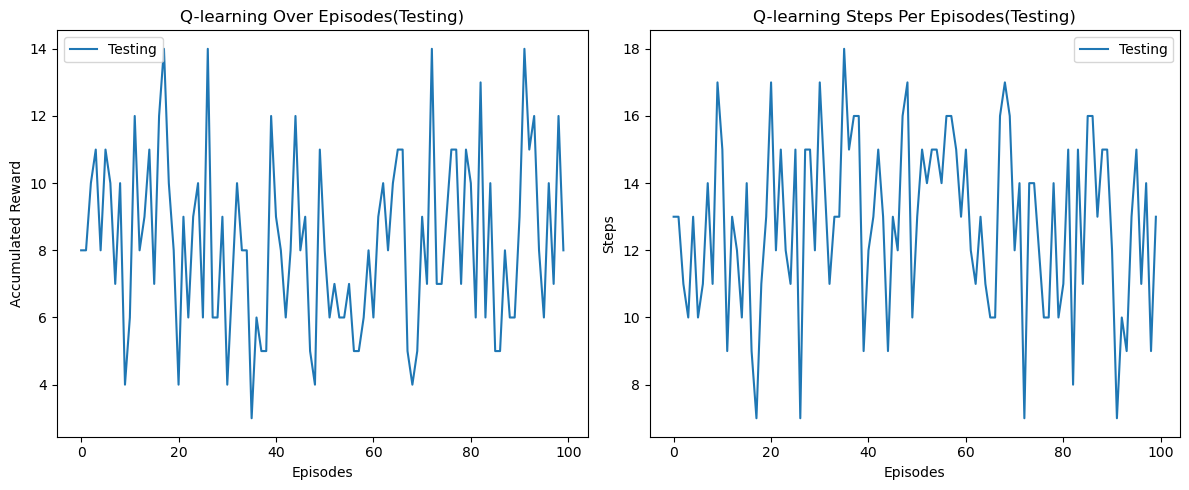

In [44]:
import matplotlib.pyplot as plt

# show plots
def show_plot_test(rewards, steps, policy):
    episodes = range(len(rewards))
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label='Testing')
    plt.xlabel('Episodes')
    plt.ylabel('Accumulated Reward')
    plt.title(f'{policy} Over Episodes(Testing)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodes, steps, label='Testing')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'{policy} Steps Per Episodes(Testing)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

show_plot_test(all_rewards_per_episode_1, all_steps_per_episode_1, "Q-learning")

-------------------------------- Visualization for Q_learning algorithm (rgb_array mode) --------------------------------


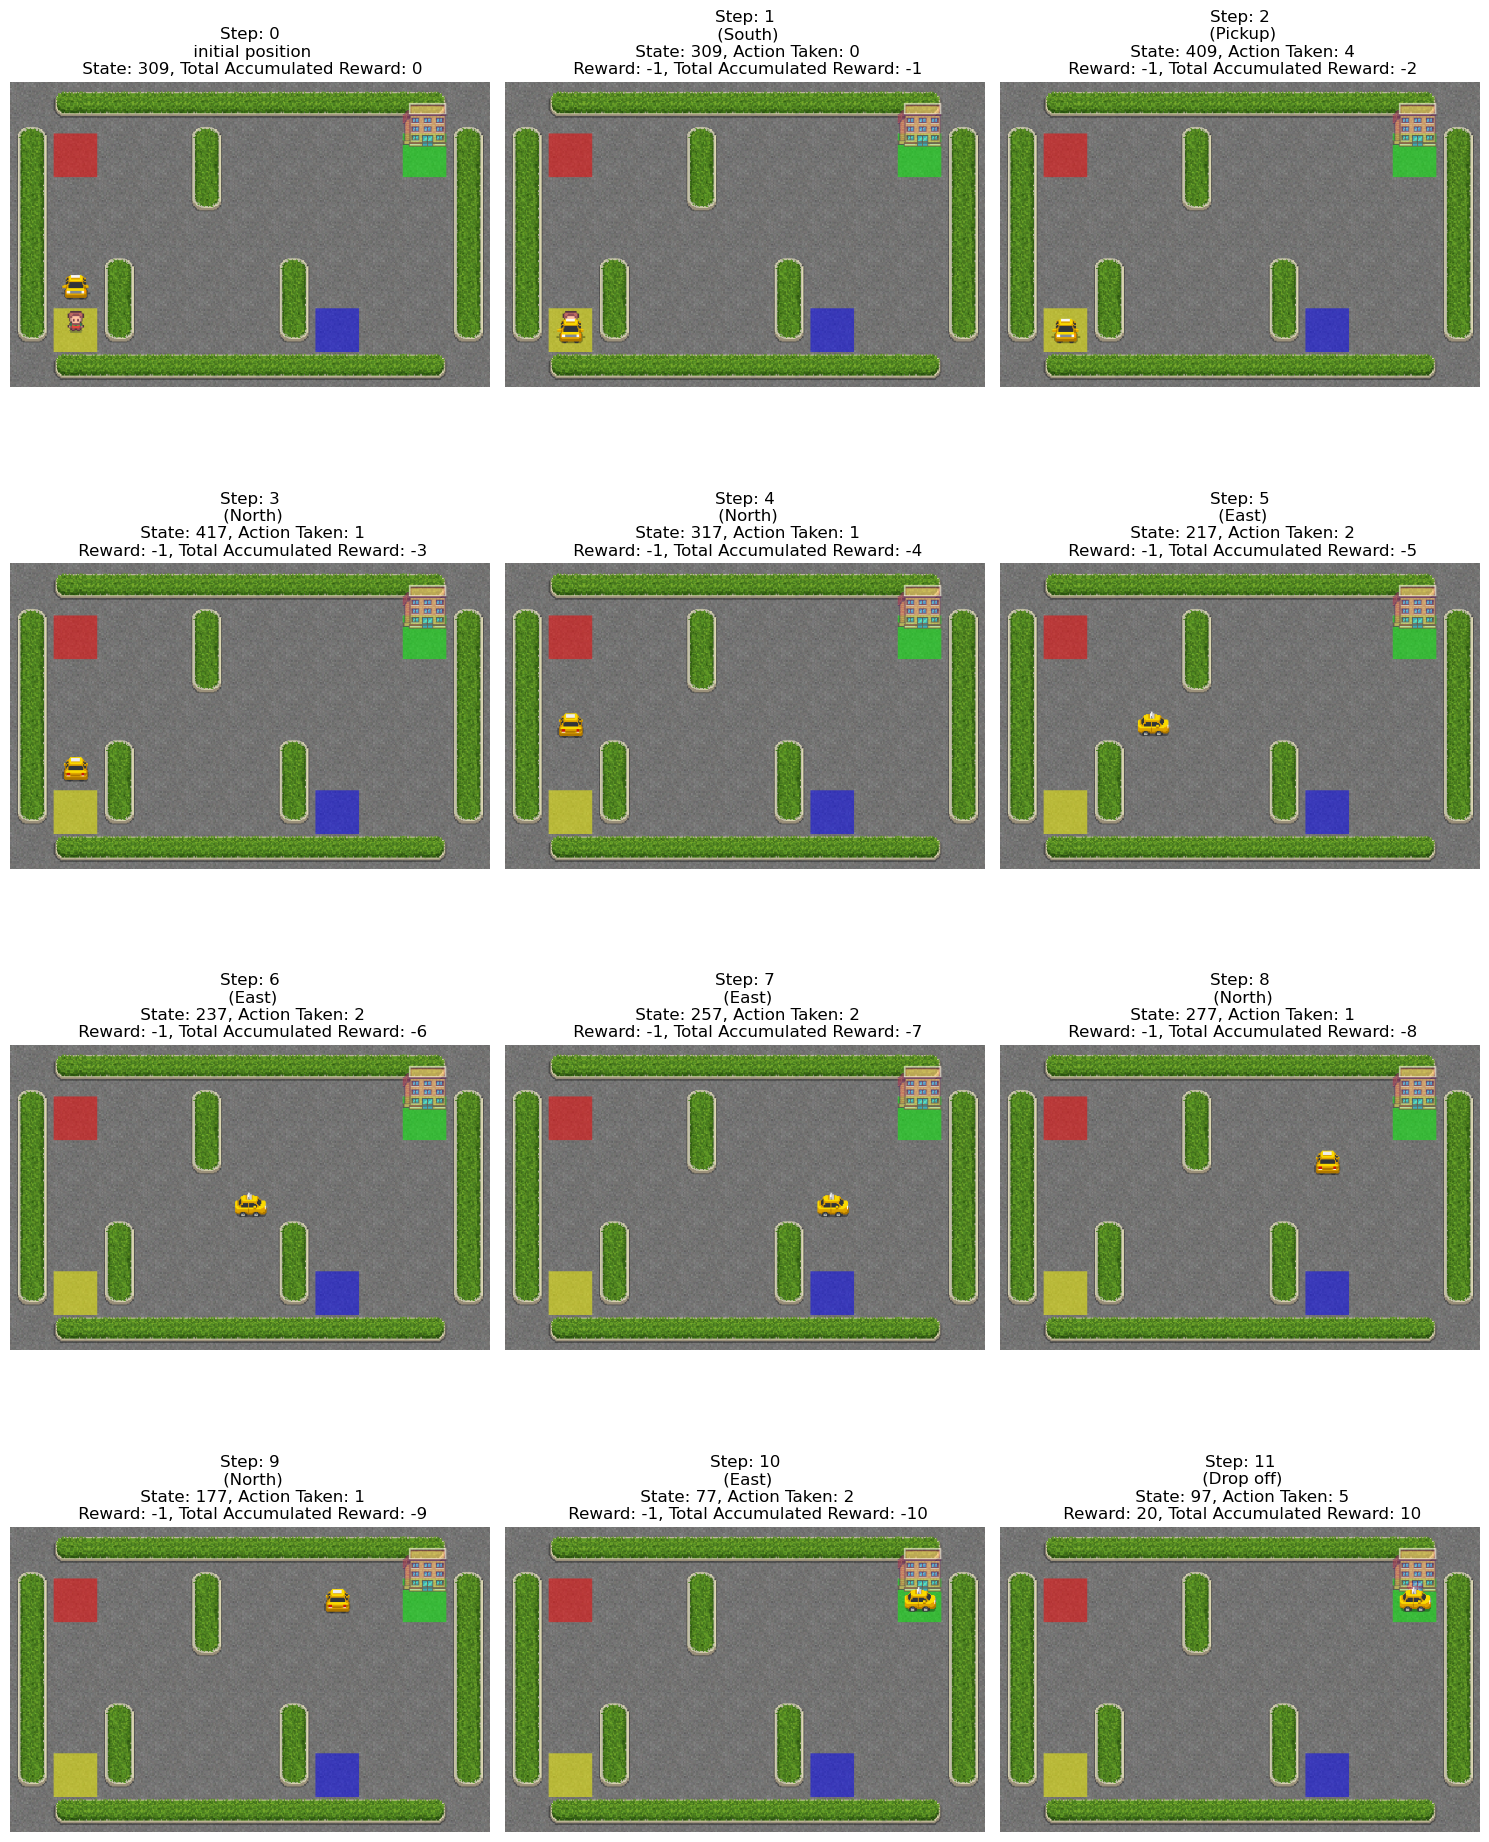

In [47]:
episode_1 = 8
print("-------------------------------- Visualization for Q_learning algorithm (rgb_array mode) --------------------------------")
visualization_rgb(episode_1, all_rendered_env_1, visualize_info_1, all_initial_1)

In [46]:
print("-------------------------------- Visualization for Q_learning algorithm (human mode) --------------------------------")
visualization_human(episode_1, all_env_seeds_1, Q_q_learning) # type: ignore
print("done")

-------------------------------- Visualization for Q_learning algorithm (human mode) --------------------------------
done


### SARSA algorithm

In [31]:
print("-------------------------------- Test for SARSA algorithm --------------------------------")
all_rendered_env_2, visualize_info_2, all_initial_2, all_env_seeds_2, all_rewards_per_episode_2, all_steps_per_episode_2 = rl_test(env, episodes, Q_sarsa)

-------------------------------- Test for SARSA algorithm --------------------------------
Average reward: 7.57
Average steps per episode: 13.43


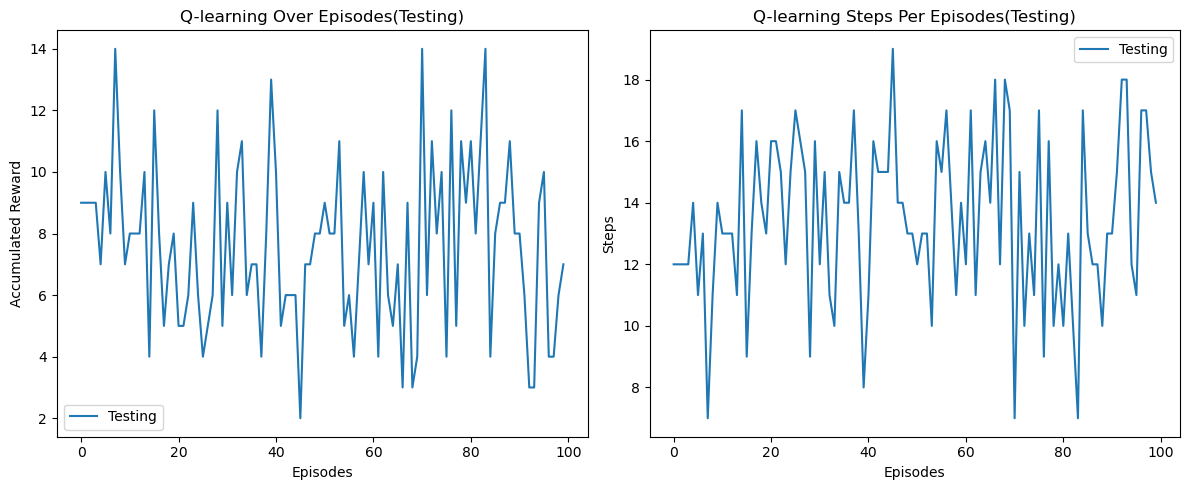

In [32]:
show_plot_test(all_rewards_per_episode_2, all_steps_per_episode_2, "Q-learning")

-------------------------------- Visualization for SARSA algorithm --------------------------------


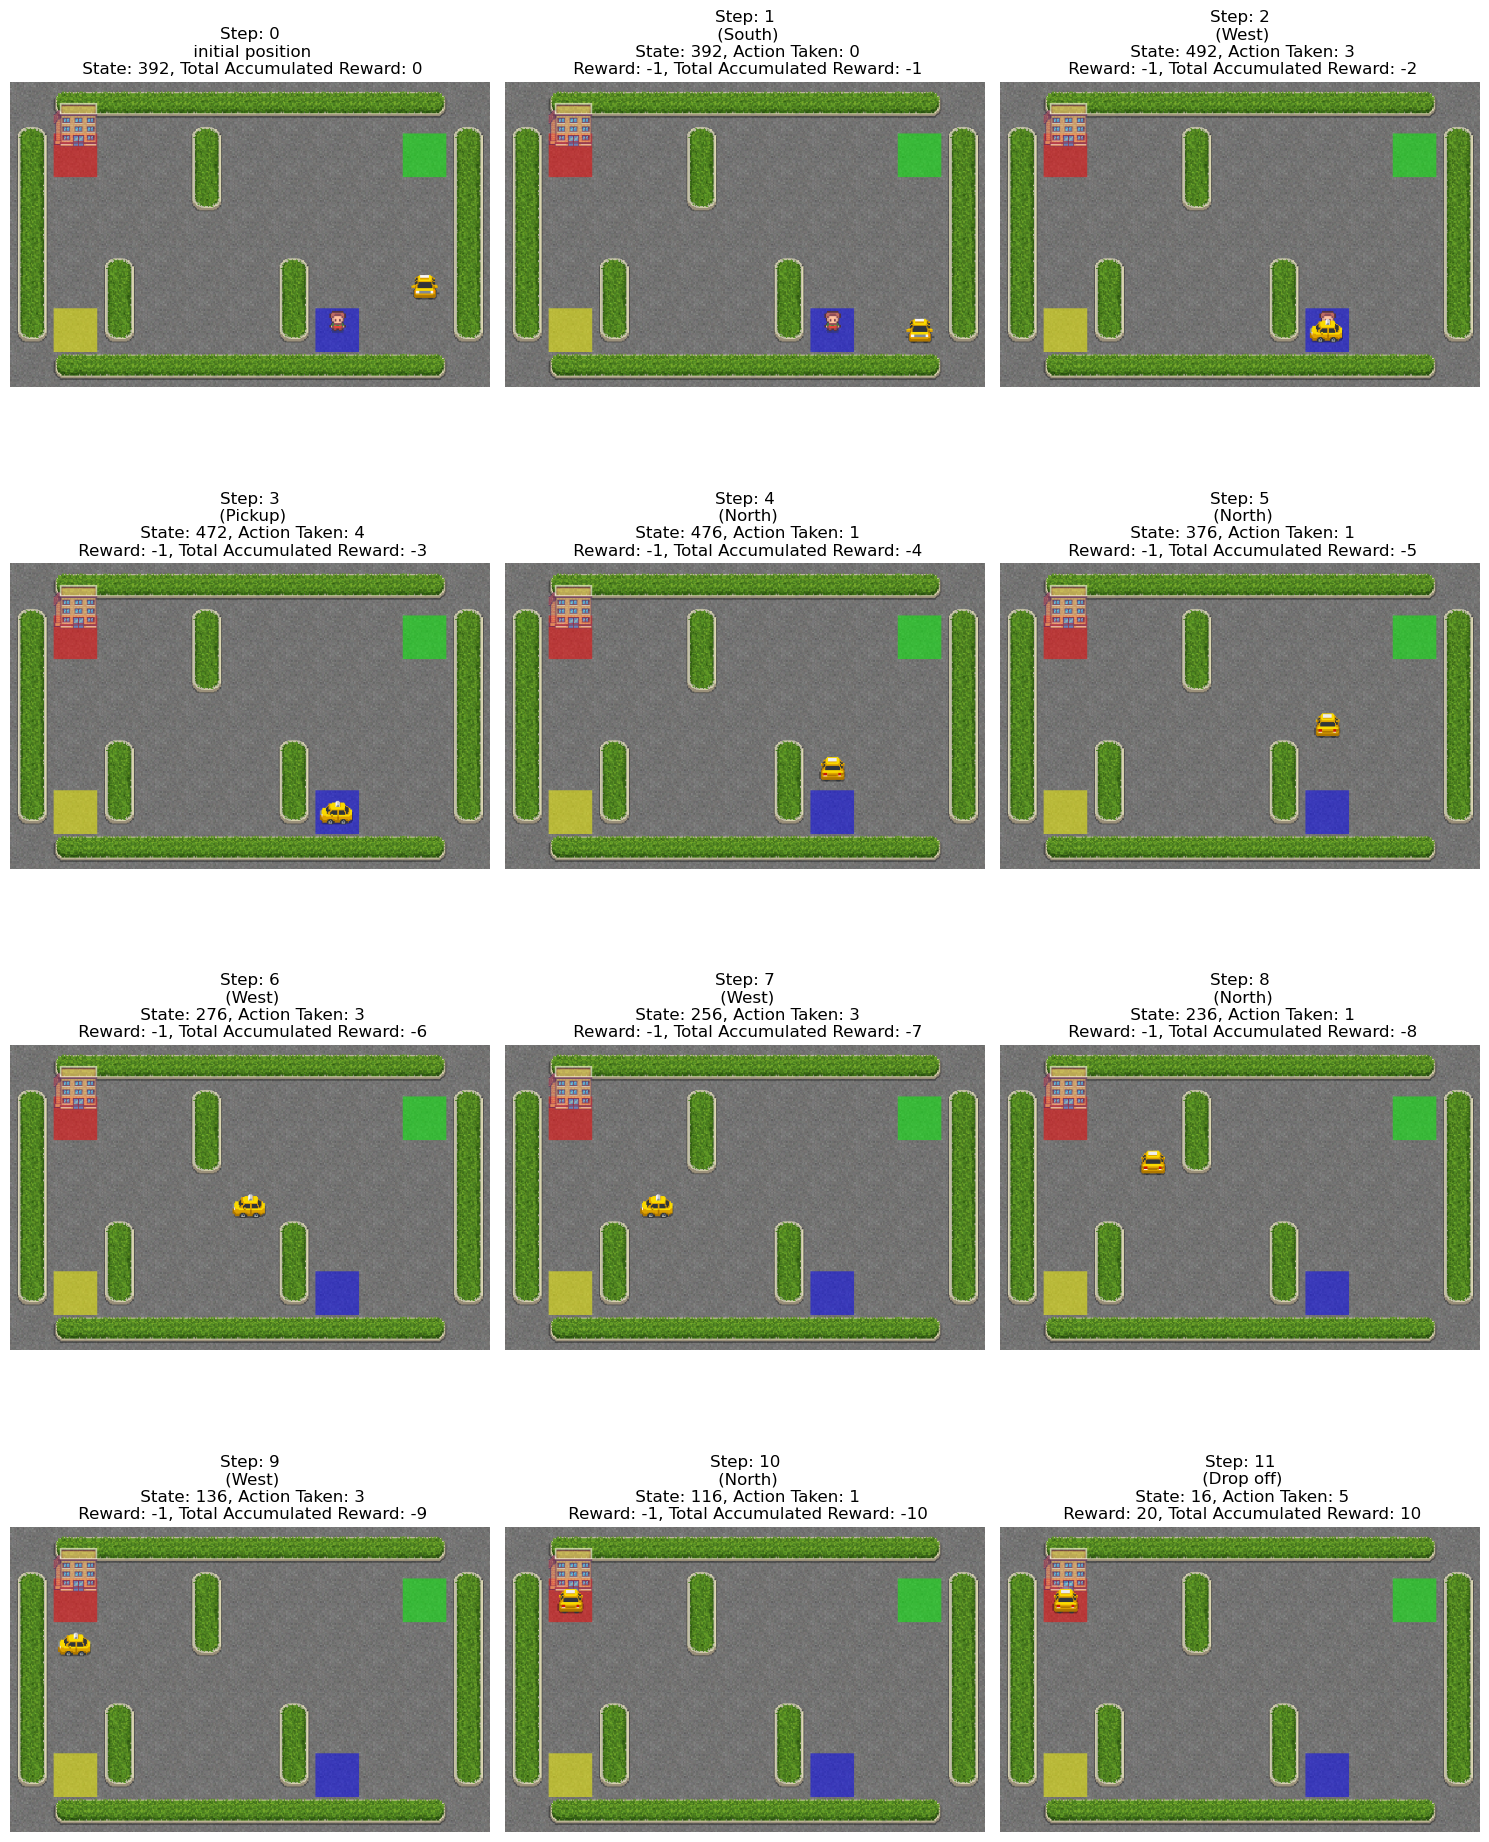

In [51]:
episode_2 = 5
print("-------------------------------- Visualization for SARSA algorithm --------------------------------")
visualization_rgb(episode_2, all_rendered_env_2, visualize_info_2, all_initial_2)

In [34]:
print("-------------------------------- Visualization for SARSA algorithm (human mode) --------------------------------")
visualization_human(episode_2, all_env_seeds_2, Q_sarsa) 
print("done")

-------------------------------- Visualization for SARSA algorithm (human mode) --------------------------------
done
